In [2]:
# Importamos librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

In [3]:
# Importamos el set de testeo provisto
inmuebles = pd.read_parquet("train.parquet")

In [4]:
# Revisamos las primeras lineas del dataset
inmuebles.head()


,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,0,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,0,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn


In [6]:
# Revisamos existencia de valores nulos
inmuebles.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             71171
parking_options            126682
image_url                       0
description                     2
lat                          1722
long                         1722
state                           0
dtype: int64

In [7]:
# Vamos a crear la nueva columna con las dos categorias de precios (1 = low, 0 = medium & high)
conditions = [
    (inmuebles['price'] >= 0) & (inmuebles['price'] <= 999),
    (inmuebles['price'] >= 1000)]
choices = ['1', '0']
inmuebles['category_price'] = np.select(conditions, choices).astype(int)

In [8]:
inmuebles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346479 entries, 0 to 346478
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       346479 non-null  int64  
 1   url                      346479 non-null  object 
 2   region                   346479 non-null  object 
 3   region_url               346479 non-null  object 
 4   price                    346479 non-null  int64  
 5   type                     346479 non-null  object 
 6   sqfeet                   346479 non-null  int64  
 7   beds                     346479 non-null  int64  
 8   baths                    346479 non-null  float64
 9   cats_allowed             346479 non-null  int64  
 10  dogs_allowed             346479 non-null  int64  
 11  smoking_allowed          346479 non-null  int64  
 12  wheelchair_access        346479 non-null  int64  
 13  electric_vehicle_charge  346479 non-null  int64  
 14  come

In [9]:
# Verificamos valores de la nueva columna y existencia de nulos
inmuebles.category_price.unique()

array([0, 1])

In [10]:
inmuebles.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             71171
parking_options            126682
image_url                       0
description                     2
lat                          1722
long                         1722
state                           0
category_price                  0
dtype: int64

<AxesSubplot: xlabel='category_price', ylabel='count'>

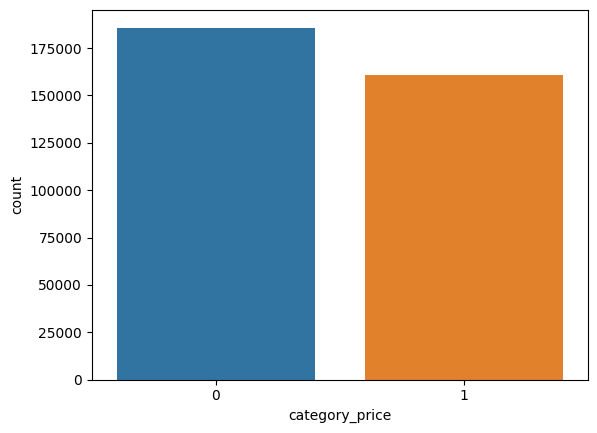

In [11]:
# Graficamos la distribución de la nueva columna
sns.countplot(x='category_price', data=inmuebles)

Vemos que las clases se encuentran balanceadas

In [12]:
# Verificamos existenvia de filas duplicadas
len(inmuebles)-len(inmuebles.drop_duplicates())

0

In [13]:
inmuebles.shape

(346479, 23)

Explorando el dataset, encontramos Descripciones repetidas, generalmente con mismo precio de alquiler y mismo URL de la imagen de la propiedad, por lo que decidimos eliminar estos registros repetidos dejando solamente uno, utilizando para ello la columna de la URL de la imagen ya que es la que mayor confianza nos otorga en cuanto a que se trata de la misma propiedad en alquiler.

Consideramos que el dato de cuantas veces se publicó la misma propiedad puede ser un indicativo del valor de su alquiler. Por lo tanto, vamos a incorporar una columna con la cantidad de veces que se publicó el aviso.

In [14]:
# Contamos la cantidad de valores repetidos en la columna "image_url"
len(inmuebles['image_url'])-len(inmuebles['image_url'].drop_duplicates())

178233

Vemos que un número importante, practicamente la mitad del dataset contiene republicaciones de la misma propieadad en alquiler

In [15]:
# Buscamos algun ejemplo para visualizar
df = inmuebles.loc[inmuebles['image_url'].duplicated(keep=False),'image_url']
df
df = df.groupby(df).apply(lambda x: tuple(x.index)).tolist()
df[24]

(66499, 70514, 173295, 215379, 309342, 331892)

In [16]:
inmuebles.loc[[66499,70514, 173295,215379,309342,331892],['price','image_url','description']]

,price,image_url,description
66499,1164,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
70514,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
173295,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
215379,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
309342,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
331892,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...


Conciden los datos, con una pequeña variación en el costo del alquiler que puede deberse al paso del tiempo y la inflaciòn de Estados Unidos

In [17]:
# Incorporamos una columna "publicaciones" que contiene la cantidad de veces que aparece el mismo anuncio en el dataset
inmuebles['publicaciones'] = inmuebles.groupby(['image_url'])['image_url'].transform('count')
inmuebles

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,category_price,publicaciones
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id,0,1
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co,0,2
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va,0,1
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az,0,1
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346474,7050982281,https://evansville.craigslist.org/apa/d/evansv...,evansville,https://evansville.craigslist.org,672,apartment,660,1,1.0,1,...,0,laundry on site,None,https://images.craigslist.org/00x0x_9oaHKZ8Ilp...,"The pool, the office, the 24-hour on-site laun...",37.9591,-87.5293,in,1,2
346475,7049418251,https://sandiego.craigslist.org/ssd/apa/d/chul...,san diego,https://sandiego.craigslist.org,2122,apartment,1099,2,2.0,1,...,0,w/d in unit,off-street parking,https://images.craigslist.org/00O0O_6QsU4p5WMh...,Seize your chance to live in our beautiful apa...,32.6279,-117.0370,ca,0,1
346476,7048268235,https://columbia.craigslist.org/apa/d/columbia...,columbia,https://columbia.craigslist.org,1014,apartment,1104,2,2.0,1,...,0,w/d hookups,off-street parking,https://images.craigslist.org/00000_dpNWqzYhGK...,Tucked into the rolling landscape of Southeast...,33.9659,-80.9355,sc,0,7
346477,7026721229,https://nd.craigslist.org/apa/d/minot-open-con...,north dakota,https://nd.craigslist.org,935,apartment,1050,2,2.0,0,...,0,w/d in unit,detached garage,https://images.craigslist.org/00Z0Z_65g6Cty1RX...,Enjoy living at Southwood Apartments! Located ...,48.1995,-101.2800,nd,1,21


In [18]:
# Ahora si eliminamos los anuncios duplicados
inmuebles.drop_duplicates(subset='image_url', inplace=True)

In [19]:
inmuebles.shape

(168246, 24)

Efectivamente, hemos reducido el dataset en un 51,4% del total de registros originales

In [20]:
inmuebles

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,category_price,publicaciones
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id,0,1
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co,0,2
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va,0,1
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az,0,1
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346460,7046734925,https://miami.craigslist.org/brw/apa/d/fort-la...,south florida,https://miami.craigslist.org,1565,apartment,720,1,1.0,0,...,0,None,None,https://images.craigslist.org/00q0q_eqjRAloITz...,Come Home to Bell at Plantation Apartments in ...,26.1467,-80.2433,fl,0,1
346462,7031598723,https://dayton.craigslist.org/apa/d/dayton-dec...,dayton / springfield,https://dayton.craigslist.org,479,apartment,562,1,1.0,1,...,0,laundry on site,off-street parking,https://images.craigslist.org/00s0s_8MWbqu0lvf...,Avalon Place Apartments & Townhomes 2196 Rockd...,39.7824,-84.0271,oh,1,1
346466,7045689575,https://boston.craigslist.org/gbs/apa/d/brookl...,boston,https://boston.craigslist.org,3155,apartment,896,1,1.0,0,...,0,w/d in unit,None,https://images.craigslist.org/00P0P_egXeeJ2jUR...,PROPERTY INFO ID: 184600979Rent: 3155 / MonthB...,42.3431,-71.1230,ma,0,1
346475,7049418251,https://sandiego.craigslist.org/ssd/apa/d/chul...,san diego,https://sandiego.craigslist.org,2122,apartment,1099,2,2.0,1,...,0,w/d in unit,off-street parking,https://images.craigslist.org/00O0O_6QsU4p5WMh...,Seize your chance to live in our beautiful apa...,32.6279,-117.0370,ca,0,1


<AxesSubplot: xlabel='category_price', ylabel='count'>

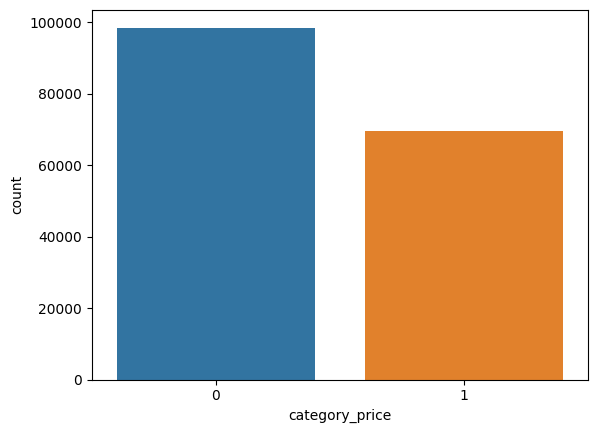

In [21]:
# Volvemos a revisar la distribución del target
sns.countplot(x='category_price', data=inmuebles)

Vamos a analizar ahora cada columna en particular

In [22]:
inmuebles.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long,category_price,publicaciones
count,1.682460e+05,1.682460e+05,1.682460e+05,168246.000000,168246.000000,168246.000000,168246.000000,168246.000000,168246.000000,168246.000000,168246.000000,167328.000000,167328.000000,168246.000000,168246.000000
mean,7.041582e+09,1.823485e+04,1.130897e+03,1.984344,1.493438,0.677591,0.656836,0.679374,0.080786,0.016630,0.056958,37.686822,-94.297691,0.414209,2.059360
std,9.130467e+06,6.749396e+06,2.141155e+04,4.460110,0.647693,0.467400,0.474767,0.466719,0.272508,0.127883,0.231764,5.831513,17.412971,0.492586,4.010354
min,7.004042e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000,0.000000,1.000000
25%,7.036552e+09,8.450000e+02,7.500000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.736800,-105.125000,0.000000,1.000000
50%,7.044526e+09,1.100000e+03,9.600000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,38.250300,-89.275650,0.000000,1.000000
75%,7.049008e+09,1.500000e+03,1.200000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.683200,-81.264900,1.000000,2.000000
max,7.051292e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000,1.000000,363.000000


Analizemos "sqfeet" en busqueda de outliers

In [23]:
inmuebles.sort_values("sqfeet",ascending=False)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,category_price,publicaciones
249237,7017516227,https://mankato.craigslist.org/apa/d/new-ulm-2...,mankato,https://mankato.craigslist.org,750,apartment,8388607,2,1.0,0,...,0,laundry in bldg,detached garage,https://images.craigslist.org/00w0w_nq1l2oBn6W...,"Description 2-bedroom, 1-bath unit with smal...",44.3262,-94.4804,mn,1,1
141803,7046432288,https://santabarbara.craigslist.org/apa/d/sant...,santa barbara,https://santabarbara.craigslist.org,11350,house,1019856,5,4.0,1,...,1,laundry in bldg,attached garage,https://images.craigslist.org/00m0m_a6iuP3382d...,Stunning Ocean View and Gated Luxury Home with...,34.4478,-119.7030,ca,0,1
47651,7046395842,https://santabarbara.craigslist.org/apa/d/sant...,santa barbara,https://santabarbara.craigslist.org,7250,house,1019856,4,2.0,1,...,1,laundry in bldg,attached garage,https://images.craigslist.org/00k0k_lqGX8GjJBg...,WALK EVERYWHERE IN SANTA BARBARA! Wonderfully ...,34.4308,-119.7020,ca,0,1
241443,7046343123,https://syracuse.craigslist.org/apa/d/syracuse...,syracuse,https://syracuse.craigslist.org,625,duplex,999999,1,1.0,0,...,0,None,off-street parking,https://images.craigslist.org/00F0F_bmaTZRhAVn...,"Rowland St Street | Apt 2 | Syracuse, NY 13204...",43.0444,-76.1758,ny,1,1
41478,7048286226,https://newlondon.craigslist.org/apa/d/new-lon...,eastern CT,https://newlondon.craigslist.org,750,apartment,999999,1,1.0,0,...,0,laundry in bldg,off-street parking,https://images.craigslist.org/00H0H_3MbpR6z8x0...,"Various one bedroom apartments All remodeled, ...",41.3507,-72.1062,ct,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49827,7039384344,https://lakeland.craigslist.org/apa/d/winter-h...,lakeland,https://lakeland.craigslist.org,900,duplex,0,2,1.0,1,...,0,w/d hookups,off-street parking,https://images.craigslist.org/00E0E_dFwnk6x3cI...,"Come Home to ""The Palms on Avenue J"" 2BR/1BA D...",28.0452,-81.7325,fl,1,7
124652,7039526517,https://boston.craigslist.org/gbs/apa/d/watert...,boston,https://boston.craigslist.org,2500,apartment,0,2,2.5,0,...,0,w/d in unit,street parking,https://images.craigslist.org/00l0l_jUWnSxUubm...,"NO BROKER FEE! 1. *Available- January 1st, 20...",42.3677,-71.1879,ma,0,1
17054,7044628513,https://annarbor.craigslist.org/apa/d/ann-arbo...,ann arbor,https://annarbor.craigslist.org,1200,house,0,1,1.5,1,...,1,w/d in unit,off-street parking,https://images.craigslist.org/00D0D_aqN2oAouB8...,One bedroom house with beautiful two room fini...,42.2403,-83.7035,mi,0,1
218523,7005593835,https://jxn.craigslist.org/apa/d/jackson-batab...,jackson,https://jxn.craigslist.org,625,apartment,0,1,1.0,1,...,0,laundry in bldg,off-street parking,https://images.craigslist.org/00S0S_lk93dLD8UQ...,"We have 1 Bedrooms and 2 Bedrooms. 1st floor, ...",42.2765,-84.4442,mi,1,1


Vemos que hay valores muy altos y valores en cero. De acuerdo a este artículo (https://www.ahs.com/home-matters/real-estate/the-2022-american-home-size-index/) el promedio de square feet de las viviendas en Estados Unidos se acerca de 2.000.
Por lo tanto, podemos considerar los valores superiores a 50.000 como errores (especialmente tratandose de alquileres).
Tambien consideraremos errores los valores de cero y muy bajos, ya que de acuerdo a este otro artículo (https://www.nyrentownsell.com/blog/square-footage-guide-to-living-real-life-home-example/) , 200 square feets es el mínimo para que la vivienda sea habitable
Calcularemos los outliers a continuacion utilizando el método del Rango Intercuartílico

In [25]:
def outlier_treatment(datacolumn):
    """
    Definimos una función para detectar outliers
    """
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [26]:
# Obtenemos los valores límites inferior y superior
lowerbound,upperbound = outlier_treatment(inmuebles.sqfeet)
print ("Lower:",lowerbound," ","Upper",upperbound)


Lower: 75.0   Upper 1875.0


In [27]:
#Obtenemos algunos ejemplos de outliers
inmuebles[(inmuebles.sqfeet < lowerbound) | (inmuebles.sqfeet > upperbound)]

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,category_price,publicaciones
33,7032658920,https://prescott.craigslist.org/apa/d/prescott...,prescott,https://prescott.craigslist.org,2500,house,3622,3,2.0,1,...,0,w/d in unit,attached garage,https://images.craigslist.org/00D0D_6FAXLgugIp...,Ranch at Prescott home backs to the Prescott N...,34.4958,-112.3780,az,0,1
42,7043485903,https://albany.craigslist.org/apa/d/albany-roo...,albany,https://albany.craigslist.org,2975,apartment,1946,2,2.0,1,...,0,w/d in unit,detached garage,https://images.craigslist.org/00a0a_5p2eIdMlBN...,"***If you are inquiring by email, please inclu...",42.6362,-73.7545,ny,0,2
48,7024919810,https://treasure.craigslist.org/apa/d/port-sai...,treasure coast,https://treasure.craigslist.org,1750,house,2424,3,2.0,0,...,0,None,None,https://images.craigslist.org/00w0w_43uLLx92Pb...,Beautiful PSL Home. Back patio will be refurbi...,27.2889,-80.2980,fl,0,1
74,7044025591,https://sandiego.craigslist.org/csd/apa/d/san-...,san diego,https://sandiego.craigslist.org,4500,apartment,2000,3,2.5,0,...,1,w/d in unit,attached garage,https://images.craigslist.org/00P0P_aUxDoj4L4M...,Newer Condo (build in 2008) with Ocean Views. ...,32.7927,-117.2540,ca,0,3
144,7048383653,https://reno.craigslist.org/apa/d/sparks-6578-...,reno / tahoe,https://reno.craigslist.org,1995,house,2172,3,3.5,0,...,0,w/d hookups,attached garage,https://images.craigslist.org/00U0U_c6Td50scIz...,6578 Aston Circle Sparks NV 89436 ...,39.6132,-119.6910,ca,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346026,7046428127,https://honolulu.craigslist.org/oah/apa/d/hono...,hawaii,https://honolulu.craigslist.org,4500,house,1950,3,2.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00m0m_cF4sBpSiEe...,This gorgeous three-bedroom two bath single fa...,21.3117,-157.8300,hi,0,1
346192,7015150936,https://charlottesville.craigslist.org/apa/d/c...,charlottesville,https://charlottesville.craigslist.org,2275,house,3536,4,3.0,0,...,0,w/d in unit,off-street parking,https://images.craigslist.org/00i0i_3ckkrYFzQ4...,Short or Long term considered ( min 4 months w...,38.0580,-78.4411,va,0,1
346216,7035130210,https://sarasota.craigslist.org/apa/d/venice-2...,sarasota-bradenton,https://sarasota.craigslist.org,1650,house,2043,2,2.0,0,...,0,w/d in unit,attached garage,https://images.craigslist.org/00C0C_5fp3PRC8Yk...,Annual Rental 2BR/2BA/2CG single family home i...,27.0791,-82.3889,fl,0,1
346338,7050590699,https://harrisburg.craigslist.org/apa/d/carlis...,harrisburg,https://harrisburg.craigslist.org,1025,condo,1883,4,2.0,0,...,0,None,None,https://images.craigslist.org/00v0v_bpPVCDZJhL...,A park-like setting surrounds this updated cha...,40.2526,-77.2002,pa,0,1


<AxesSubplot: xlabel='sqfeet'>

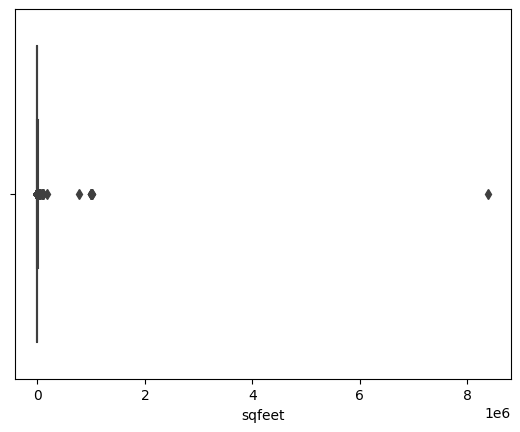

In [28]:
# Graficamos
sns.boxplot(x="sqfeet", data=inmuebles)

<AxesSubplot: xlabel='sqfeet'>

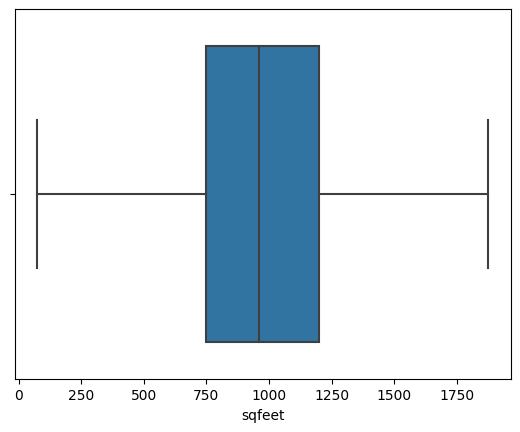

In [29]:
# Graficamos sin outliers
sns.boxplot(x = 'sqfeet', data = inmuebles, showfliers = False)

Como vemos en las gráficas, la cantidad de valores errones es importante. Por un lado, el valor mínimo de 75 squarefeet es muy bajo en relacion a los 200 squarefeet mencionados, con muchos casos dentro del primer cuartil con esos valores, y por otro lado, el valor mínimo de 1.875 es inferior al promedio del tamaño de viviendas en Estados Unidos.
Tomaremos entonces como valor mínimo válido 200 squarefeet y como valor máximo, 10.000 squarefeet, reemplazando los valores que exceden los límites, por dichos límites.

In [30]:
inmuebles['sqfeet'].mask(inmuebles['sqfeet'] < 200, 200, inplace=True)

In [31]:
inmuebles['sqfeet'].mask(inmuebles['sqfeet'] > 10000, 10000, inplace=True)

<AxesSubplot: xlabel='sqfeet'>

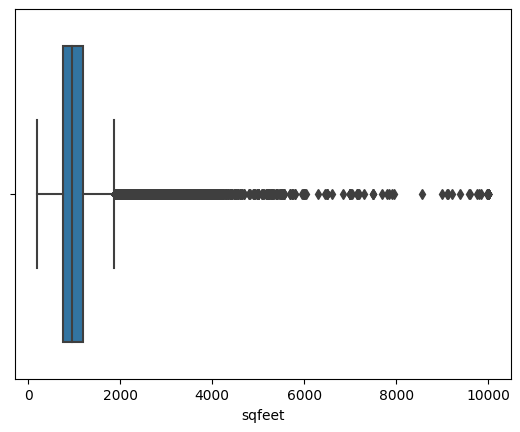

In [32]:
# Volvemos a graficar
sns.boxplot(x="sqfeet", data=inmuebles)

Si bien a simple vista la gráfica indicaria la presencia abundante de outliers aún, consideramos que se relaciona satisfactoriamente a los datos recolectados. Una gran cantidad de propiedades en alquiler por debajo del tamaño promedio de las mismas en Estados Unidos, y una menor cantidad de propiedades de tamaños muy superiores a la media.

La columna "publicaciones" tiene valores (si bien reales), muy superiores a la media. Tomaremos como máximo 30 publicaciones. Ademas consideramos que el set de testeo, al contar con menos casos, no tendrá tantas repeticiones

In [33]:
inmuebles['publicaciones'].mask(inmuebles['publicaciones'] > 30, 30, inplace=True)

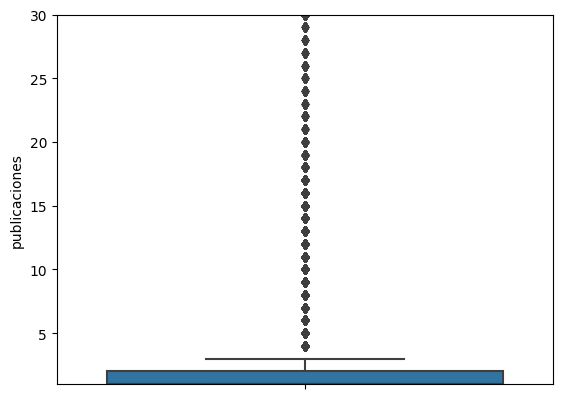

In [34]:
# Graficamos
sns.boxplot( y=inmuebles["publicaciones"] )
plt.ylim(1, 30)
plt.show()

Veamos ahora las columnas de camas y baños, que parecen tener outliers

<AxesSubplot: xlabel='beds'>

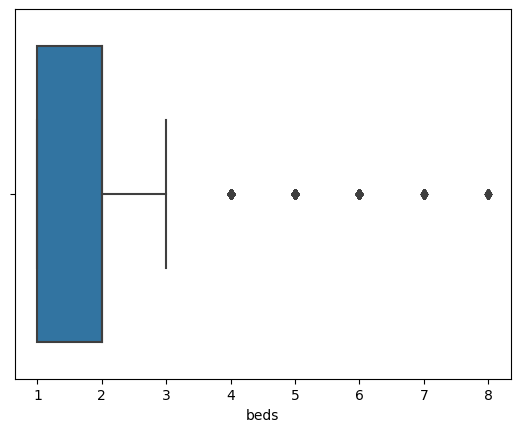

In [41]:
# Graficamos camas
sns.boxplot(x="beds", data=inmuebles)

<AxesSubplot: xlabel='beds'>

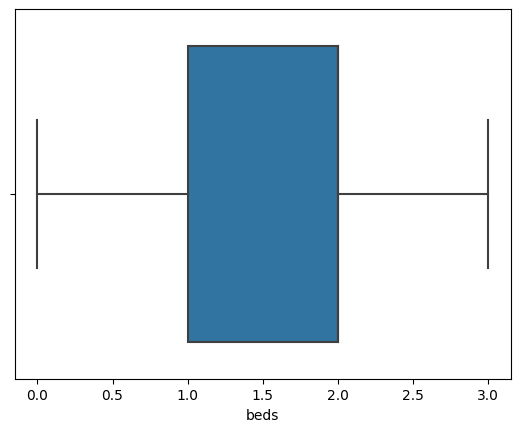

In [38]:
# Ahora sin outliers
sns.boxplot(x = 'beds', data = inmuebles, showfliers = False)

Reemplazaremos los valores en 0 por 1 y los valores mayores a 8 por 8.

<AxesSubplot: xlabel='beds'>

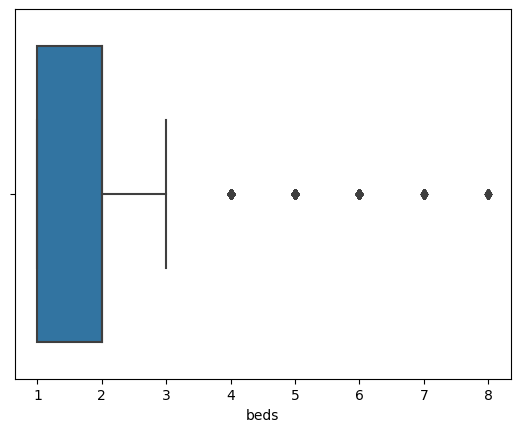

In [42]:
inmuebles['beds'].mask(inmuebles['beds'] == 0, 1, inplace=True)
inmuebles['beds'].mask(inmuebles['beds'] > 8, 8, inplace=True)
sns.boxplot(x="beds", data=inmuebles)

<AxesSubplot: xlabel='baths'>

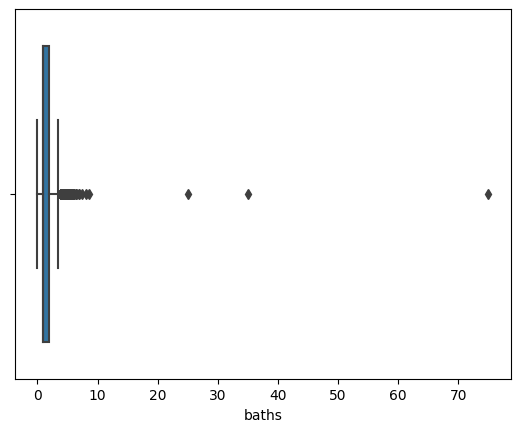

In [43]:
# Graficamos baños
sns.boxplot(x="baths", data=inmuebles)

Reemplazaremos los valores en 0 por 1 y los valores mayores a 8 por 8.

<AxesSubplot: xlabel='baths'>

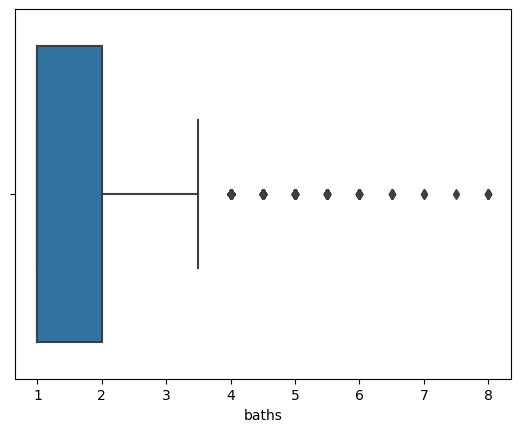

In [44]:
inmuebles['baths'].mask(inmuebles['baths'] == 0, 1, inplace=True)
inmuebles['baths'].mask(inmuebles['baths'] > 8, 8, inplace=True)
sns.boxplot(x="baths", data=inmuebles)

Revisamos ahora la columna de Longitud. Vemos que hay valores en positivo que son erroneos, muchos casos son de Arkansas y vemos que si lo pasamos a negativo, coinciden con la ubicacion de ese Estado. Les cambiamos entonces el signo a los positivos y pasamos a -67.482 los valores mayores

In [48]:
inmuebles["long"] = inmuebles["long"].abs()*(-1)

In [50]:
inmuebles['long'].mask(inmuebles['long'] > (-67.482), (-67.482), inplace=True)

In [53]:
# Revisamos existencia de valores nulos
inmuebles["long"].isnull().sum()

918

In [59]:
# Reemplazamos nulos por el promedio
inmuebles['long'].fillna(int(inmuebles['long'].mean()), inplace=True)

Revisamos la columna de Servicio de Lavanderia. Vemos las opciones que contiene.

In [76]:
inmuebles["laundry_options"].unique()

array([4, 1, 2, 0, 3], dtype=int64)

In [77]:
inmuebles.laundry_options.isnull().sum()

0

Vemos que la cantidad de valores nulos es importante. Asumiremos que corresponden a que el inmueble no tiene el servicio

In [70]:
inmuebles["laundry_options"].fillna("no laundry on site", inplace = True)
inmuebles.laundry_options.isnull().sum()

Convertimos la variable categorica en numérica. Lo hacemos de manera manual para ordenar los valores de acuerdo a la existencia o no del servicio

In [75]:
numeric_var = {'laundry_options': {'no laundry on site':0, 'w/d hookups':1, 'laundry on site':2, 'laundry in bldg':3, "w/d in unit":4}}
inmuebles = inmuebles.replace(numeric_var)

Revisamos la columna de Estacionamiento. Vemos las opciones que contiene.

In [78]:
inmuebles["parking_options"].unique()

array(['detached garage', 'carport', 'off-street parking', None,
       'attached garage', 'street parking', 'no parking', 'valet parking'],
      dtype=object)

In [79]:
inmuebles.parking_options.isnull().sum()

55694

Nuevamente, no podremos eliminar los nulos, y asumimos que corresponde a propiedad sin estacionamiento.
Reemplazamos los nulos y luego convertigos a valores numéricos, agrupando algunas categorias similares

In [ ]:
correlaciones = inmuebles[["id","lat","long","category_price"]].copy()

In [ ]:
correlaciones.corr()


Vemos que la longitud amerita participar del modelo debido a su correlación con el precio. Entendemos que obedece a que indica cercania con el mar.
Eliminaremos las otras tres, ademas de "price" que es un dato que no estará presente en el set de testeo de Henry, y las que creemos que no aportan valor o representan una gran dificultad para incorporar al modelo como "url", "region", "region_url", "image_url" y "description"

In [ ]:
inmuebles.drop(["id","lat","url", "region", "region_url", "image_url","description","price"],axis = 1, inplace = True)

Revisemos una matriz de correlación del estado actual del dataframe para eliminar algunas columnas adicionales que en principio no serían de utilidad

In [55]:
inmuebles.corr()

C:\Users\rcent\AppData\Local\Temp\ipykernel_4932\507452967.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  inmuebles.corr()


,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,long,category_price,publicaciones
sqfeet,1.000000,0.138858,0.569152,-0.098270,-0.048129,-0.044344,-0.016687,0.002711,0.042467,0.034522,-0.241504,-0.042820
beds,0.138858,1.000000,0.408297,-0.022402,-0.012331,-0.001778,-0.012305,-0.006025,0.001903,0.009965,-0.034109,-0.009218
baths,0.569152,0.408297,1.000000,-0.023382,0.025353,-0.004964,0.010564,0.003721,0.034285,-0.018939,-0.221605,-0.011017
cats_allowed,-0.098270,-0.022402,-0.023382,1.000000,0.862133,0.063539,0.138090,0.062657,-0.060156,0.033714,0.010852,0.055057
dogs_allowed,-0.048129,-0.012331,0.025353,0.862133,1.000000,0.059451,0.142567,0.062671,-0.032597,0.014037,-0.004047,0.056126
smoking_allowed,-0.044344,-0.001778,-0.004964,0.063539,0.059451,1.000000,-0.177354,-0.093598,-0.140528,0.157595,0.129322,0.057484
wheelchair_access,-0.016687,-0.012305,0.010564,0.138090,0.142567,-0.177354,1.000000,0.236725,0.151782,-0.023561,-0.041530,0.000219
electric_vehicle_charge,0.002711,-0.006025,0.003721,0.062657,0.062671,-0.093598,0.236725,1.000000,0.080343,-0.054584,-0.061232,-0.014905
comes_furnished,0.042467,0.001903,0.034285,-0.060156,-0.032597,-0.140528,0.151782,0.080343,1.000000,-0.014701,0.006593,-0.019164
long,0.034522,0.009965,-0.018939,0.033714,0.014037,0.157595,-0.023561,-0.054584,-0.014701,1.000000,0.170015,0.047174


C:\Users\rcent\AppData\Local\Temp\ipykernel_4932\323934792.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(inmuebles.corr(method='spearman')[['category_price']].sort_values(by='category_price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')


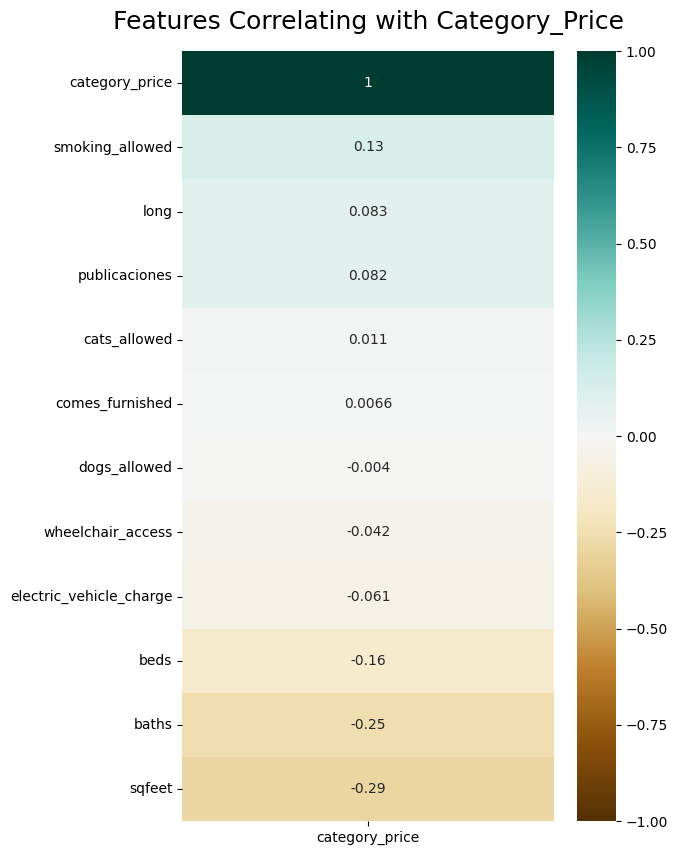

In [56]:
# Graficamos)
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(inmuebles.corr(method='spearman')[['category_price']].sort_values(by='category_price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Category_Price', fontdict={'fontsize':18}, pad=16);


In [ ]:
# Vemos la distribución de la columna "type"
sns.countplot(y='type', data=inmuebles)

In [ ]:
# Veamos la relación entre el precio del alquiler y el tipo de vivienda
agr = inmuebles.groupby(['type', 'category_price']).size().reset_index().pivot(columns='category_price', index='type', values=0)
agr.plot(kind='bar', stacked=True)

Notamos que en las casas, condominios y townhouses la proporcion de alquileres mayores a $999 es mayor, por lo que en principio dejariamos esta columna

In [ ]:
# Hacemos una descripción del Dataframe
inmuebles.describe()

Notamos la existencia de outliers en varias columnas, por ejemplo, un valor máximo de 1.100 camas o 75 baños. Analizaremos a continuación cada una de las columnas

In [ ]:
inmuebles.corr()

Como vemos en este artículo online (https://www.fool.com/the-ascent/research/average-house-price-state/#:~:text=The%20median%20home%20price%20in,in%20the%20U.S.%20at%20%24354%2C649.), el Estado en el cual se ubican las propiedades tiene gran influencia sobre el precio promedio de las mismas.
Por lo tanto, vamos a utilizar la columna "state", pero necesitamos transformarla en valores numéricos.
Haremos esto mediante el método de Binary Encoding, ya que el One-Hot Encoding nos crearía demasiadas nuevas columnas

In [ ]:
inmuebles_ce = inmuebles.copy()

encoder = ce.BinaryEncoder(cols=['state'])
inmuebles_binary = encoder.fit_transform(inmuebles_ce)

inmuebles_binary.head()

In [ ]:
# Pasamos a valores numericos la clase "category_price" para poder analizar correlaciones

inmuebles_binary['categoria']=inmuebles_binary["category_price"]
inmuebles_binary['categoria'].replace(['low', 'medium', 'high'],
                        [0, 1, 2], inplace=True)

In [ ]:
# Generamos un dataframe para hacer las primeras pruebas
inmuebles_v1 = inmuebles_binary

In [ ]:
# Eliminamos columnas que no usaremos en este primer modelo
inmuebles_v1.drop(['id', 'url', 'region', 'region_url', 'description', 'lat', 'long'], axis = 1, inplace = True)

In [ ]:
inmuebles_v1.drop(['image_url'], axis=1, inplace=True)

In [ ]:
inmuebles_v1.corr()

In [ ]:
inmuebles_v1.baths.max()